The code for this seminar is based on a code by Alexandr Verinov.  

# Seminar on generative models

In this seminar we will try several criterias for learning an implicit model.

- Start with a vanilla Generative Adversarial Networks (GAN).
- Note, that G objective can be of two kinds: $min_G log(1-D)$ and $min_G -log(D)$. Both are correct to use, but what is the practical difference? You can also try both.
- You can try to implement Wasserstein GAN. To make a function Lipschitz you can clip model's weights to [-0.01, 0.01].
- Then, you can try to implement MMD. You need to implement RBF kernel $k(x,x')=\exp \left(-{\frac  {1}{2\sigma ^{2}}}||x-x'||^{2}\right)$ and an MMD estimator (see eq.8 from https://arxiv.org/pdf/1505.03906.pdf).

# Imports

In [1]:
import numpy as np
import time
import os
# os.environ['THEANO_FLAGS'] = 'device=gpu'
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = 12, 12
np.random.seed(12345)
lims=(-5,5)

# Define sampler from real data and Z 

In [2]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

In [3]:
def vis_data(data):
    hist = np.histogram2d(data[:,1], data[:,0], bins=100, range=[lims,lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = sample_noise(1000)
def vis_g():
    data = g_generate(fixed_noise)
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
def vis_d():
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
    grads = -d_grad(fixed_noise, np.vstack([X, Y]).T.astype(np.float32))
    plt.quiver(X, Y, grads[:,0], grads[:,1], color='black',alpha=0.9)

# Define architectures

#### Generator

In [4]:
# Generator
tnoise = T.matrix('z')
l = lgen_input = lasagne.layers.InputLayer((None, NOISE_DIM), tnoise)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.tanh)
l = lasagne.layers.DenseLayer(l, num_units = 100,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.leaky_rectify)
g_net = lasagne.layers.DenseLayer(l, num_units = 2,
                  W=lasagne.init.GlorotNormal(),
                  nonlinearity=lasagne.nonlinearities.identity)
g_output = lasagne.layers.get_output(g_net)

#### Discriminator

In [19]:
# We create two nets with shared parameters
# Alternatively we could stack real and fake samples and use one network

tdata = T.matrix('x')
l                = lasagne.layers.InputLayer((None, 2), g_output)
ld = ldisc_input = lasagne.layers.InputLayer((None, 2), tdata)

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.tanh,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.tanh,
                  **{v.name:v for v in l.params.keys()})

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  **{v.name:v for v in l.params.keys()})

l = lasagne.layers.DenseLayer(l, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  W=lasagne.init.GlorotNormal())
ld = lasagne.layers.DenseLayer(ld, num_units = 100,
                  nonlinearity=lasagne.nonlinearities.leaky_rectify,
                  **{v.name:v for v in l.params.keys()})

#l = d_for_fake = lasagne.layers.DenseLayer(l, num_units = 1,
#                  nonlinearity=lasagne.nonlinearities.sigmoid,
#                  W=lasagne.init.GlorotNormal())
#ld = d_for_real = lasagne.layers.DenseLayer(ld, num_units = 1,
#                  nonlinearity=lasagne.nonlinearities.sigmoid,
#                  **{v.name:v for v in l.params.keys()})

l = d_for_fake = lasagne.layers.DenseLayer(l, num_units = 1,
                  nonlinearity=lasagne.nonlinearities.linear,
                  W=lasagne.init.GlorotNormal())
ld = d_for_real = lasagne.layers.DenseLayer(ld, num_units = 1,
                  nonlinearity=lasagne.nonlinearities.linear,
                  **{v.name:v for v in l.params.keys()})



# Define losses and updates

In [20]:
d_scores_fake = lasagne.layers.get_output(d_for_fake)
d_scores_real = lasagne.layers.get_output(d_for_real)

################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game
################################

# Plain GAN loss
#d_loss = (lasagne.objectives.binary_crossentropy(d_scores_real, 1)
#          + lasagne.objectives.binary_crossentropy(d_scores_fake, 0)).mean()
#g_loss = - lasagne.objectives.binary_crossentropy(d_scores_fake, 0).mean()
#g_loss = lasagne.objectives.binary_crossentropy(d_scores_fake, 1).mean()


# Wasserstein GAN loss
loss_fake = d_scores_fake.mean()
loss_real = d_scores_real.mean()
d_loss = loss_fake - loss_real
g_loss = -loss_fake


lr = theano.shared(np.float32(0.001))

g_params = lasagne.layers.get_all_params(g_net, trainable=True)
g_updates = lasagne.updates.adam(g_loss, g_params, learning_rate=lr, beta1=0.1)
g_step = theano.function([tnoise], g_loss, updates=g_updates)
g_generate = theano.function([tnoise], g_output)

d_params = lasagne.layers.get_all_params(d_for_real, trainable=True)
d_updates = lasagne.updates.adam(d_loss, d_params, learning_rate=lr, beta1=0.5)
d_step = theano.function([tnoise, tdata], d_loss, updates=d_updates)
d_grad = theano.function([tnoise, tdata], T.grad(d_loss, tdata))

Notice we are using ADAM optimizer with `beta1=0.5`. This is a common practice and works well, other optimizers tend to fail, but you can try different.

# Get real data

In [21]:
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in xrange(0, X.shape[0], batchsize):
        end = min(start+batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

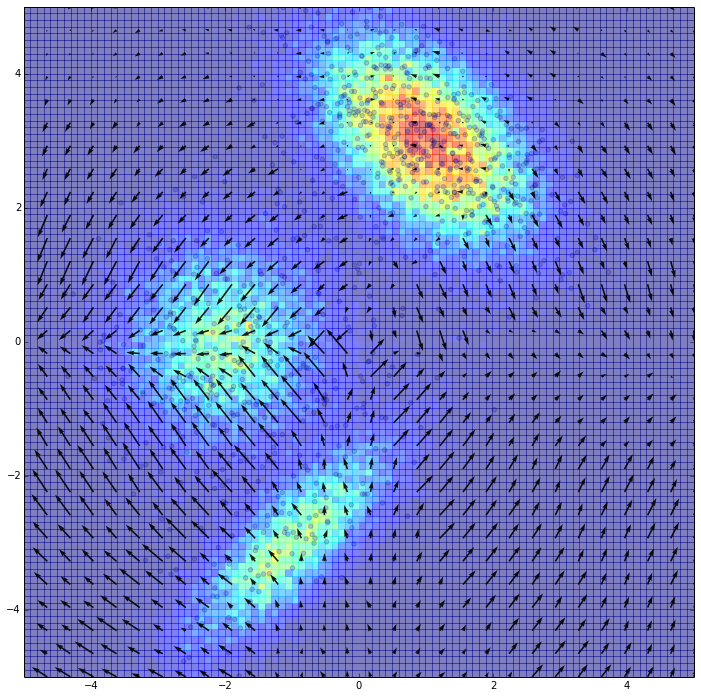

In [22]:
vis_data(data)
vis_g()
vis_d()

Here:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradient of the discriminator -- they are the directions that Discriminator pushes generator samples. 

# Train the model

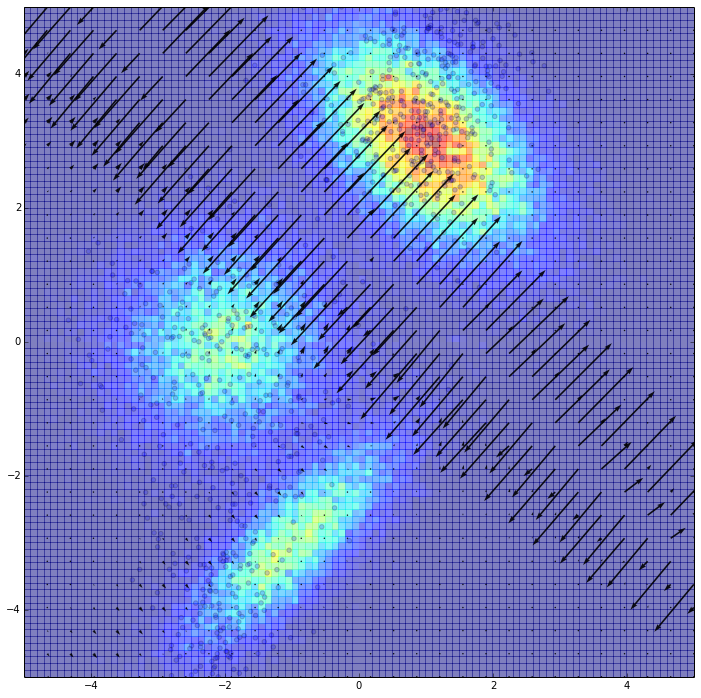

In [ ]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

lr_factor = np.float32(0.97)
# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = sample_noise(len(input_data))
                # Do an update
                d_step(noise, input_data)
    
            # Optimize G
            for _ in range(k_g):
                # Do an update
                g_step(sample_noise(batch_size))
            
            # Visualize
            plt.clf()
            vis_data(data); vis_g(); vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass